## Part 0 - Setup

## 0.1 - Imports and functions

In [25]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.decomposition import PCA
%store -r

def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = metrics.confusion_matrix(y_true, y_pred)
    sb.heatmap(c_mat, annot=False, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)

## 0.2 - Fetching datasets

In [12]:
# Fetch dataset
data_train = pd.read_csv("./EMNIST/emnist-balanced-train.csv", header=None)
data_test = pd.read_csv("./EMNIST/emnist-balanced-test.csv", header=None)

cols = ['CHAR']
for i in range(1, 785):
    cols.append(str(i))
data_train.columns = cols
data_test.columns = cols
print(data_train.shape)
print(data_test.shape)

X_train = np.array(data_train.iloc[:,1:].values)
y_train = np.array(data_train["CHAR"].values)
X_test = data_test.iloc[:,1:]
y_test = data_test["CHAR"]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
y_test.head()

(112800, 785)
(18800, 785)
(112800, 784)
(112800,)
(18800, 784)
(18800,)


0    41
1    39
2     9
3    26
4    44
Name: CHAR, dtype: int64

## Part 1 - PCA

### 1.1 - Optimizing the number of features for PCA

In [4]:
N = 784
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

In [5]:
# Checking the slope from 784 features to 1 feature
points = list(enumerate(np.cumsum(pca.explained_variance_ratio_).tolist(), start = 1))[::-1]
# Calculate instantaneous slope (pseudo-derivative)
def getSlope(curr: tuple, next: tuple):
    x1 = curr[0]
    x2 = next[0]
    y1 = curr[1]
    y2 = next[1]
    return (y2 - y1)/(x2 - x1)
scores = []
i = 0
while i < len(points) - 1:
    slope = getSlope(points[i], points[i + 1])
    stop = points[i]
    size_reduc = (1 - stop[0]/784)
    info_ret = stop[1]
    # Scoring function - For maximum feature set reduction and maximum information retained
    score = size_reduc * info_ret
    scores.append([stop[0], score, size_reduc, info_ret])
    i += 1

In [9]:
best = max(scores, key=lambda x: x[1])
print("Best number of features: " + str(best[0]))
print("Score: " + str(round(best[1] * 100, 2)))
print(f"Feature size reduction: {best[2] * 100:.2f}%")
print(f"Cumulative Variance Ratio: {best[3] * 100:.2f}%")
# Best number of features: 82
# Score: 82.56
# Feature size reduction: 89.54%
# Cumulative Variance Ratio: 92.20%

Best number of features: 82
Score: 82.56
Feature size reduction: 89.54%
Cumulative Variance Ratio: 92.20%


### 1.2 - PCA Modelling

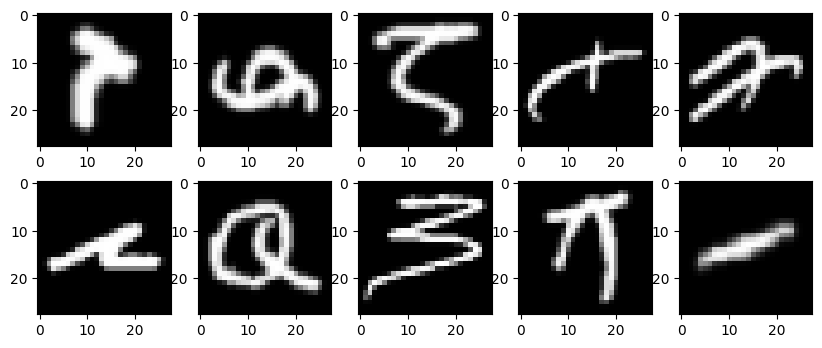

In [17]:
# Visualize what the features look like
fig,axes = plt.subplots(2,5,figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]), cmap='gray')

In [18]:
#Using PCA
N = 82 # As determined in part 1.1

pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

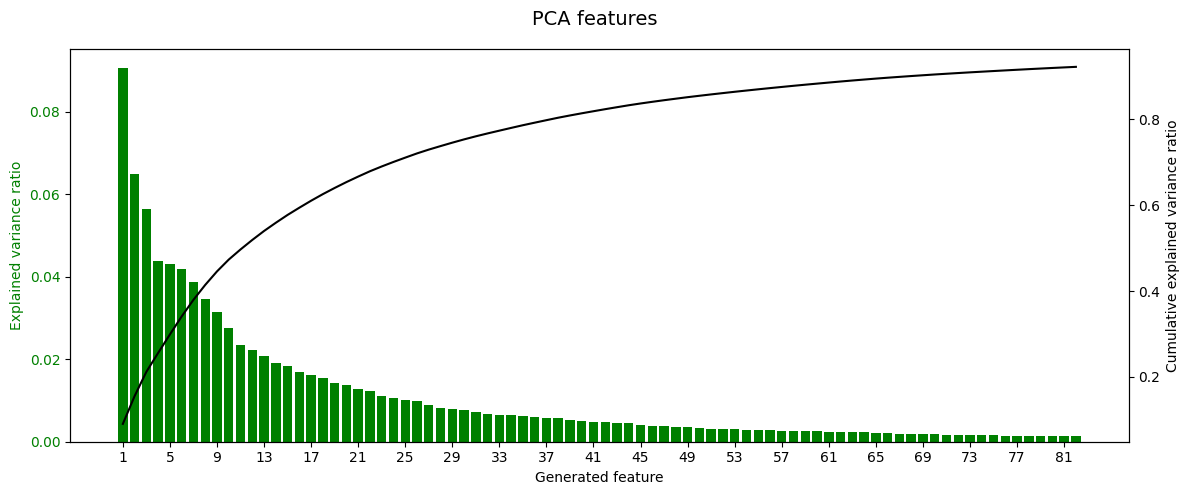

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 5))
fig.suptitle("PCA features", fontsize=14)
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color="green")
ax1.set_xticks(1+np.arange(N, step=4))
ax1.tick_params(axis='y', labelcolor="green")
ax1.set_ylabel("Explained variance ratio", color="green")
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor="black")
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color="black")
ax2.set_ylabel("Cumulative explained variance ratio", color="black")
fig.tight_layout()
plt.show()

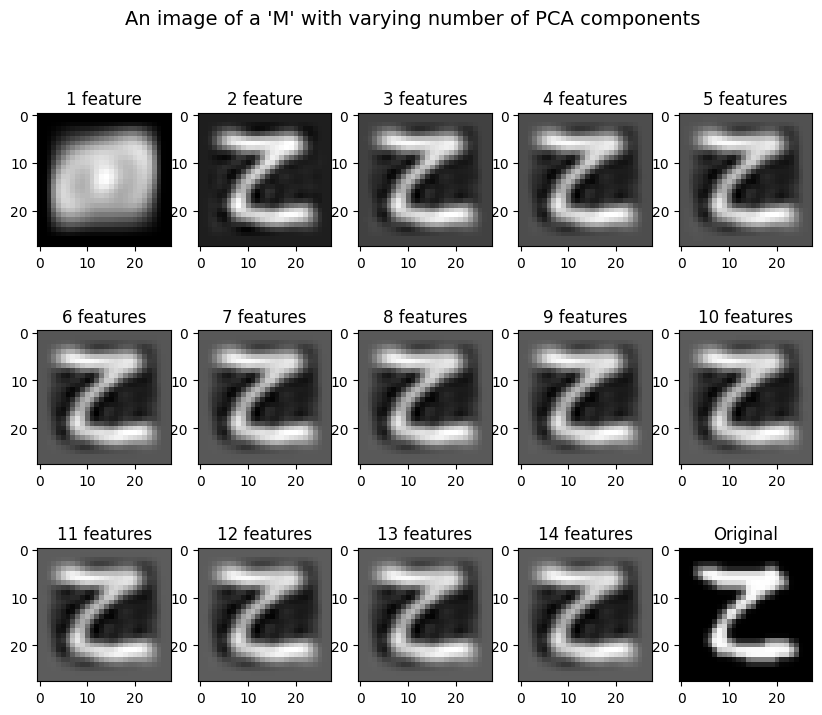

In [21]:
# Visualize the effect of PCA components
fig,axes = plt.subplots(3,5,figsize=(10,8))
fig.suptitle("An image of a 'M' with varying number of PCA components", fontsize=14, color="black")
for i,ax in enumerate(axes.flat):
    X_nfeatures = X_train_reduced[20]*[i]
    im = pca.inverse_transform(X_nfeatures).reshape(28, 28)
    ax.set_title(f"{(i+1)} feature{'s' if i>1 else ''}", color="black")
    ax.imshow(im, cmap='gray')
ax.set_title("Original")
ax.imshow(X_train[20].reshape([28,28]), cmap='gray')

In [22]:
# PCA used here
X_test_reduced = pca.fit_transform(X_test)
clfPCA = LogisticRegression(solver='sag')
x_train_reduced = pca.fit_transform(X_train)

clfPCA.fit(x_train_reduced, y_train)

LogisticRegression(solver='sag')

In [30]:
y_pred_train = clfPCA.predict(X_train_reduced)
acc_train = metrics.accuracy_score(y_train, y_pred_train)
loss_func = metrics.log_loss(y_train, clfPCA.predict_log_proba(X_train_reduced))

y_pred_test = clfPCA.predict(X_test_reduced)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
loss_func = metrics.log_loss(y_test, clfPCA.predict_log_proba(X_test_reduced))

print("Training Set")
print(f" - Accuracy: {100*acc_train:.2f}%")
print(f" - Loss: {loss_func:.2f}")
print("Testin Set")
print(f" - Accuracy: {100*acc_train:.2f}%")
print(f" - Loss: {loss_func:.2f}")

Training Set
 - Accuracy: 67.75%
 - Loss: 3.85
Testin Set
 - Accuracy: 67.75%
 - Loss: 3.85


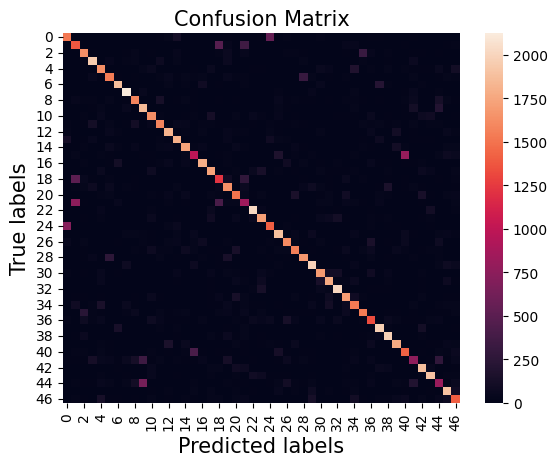

In [33]:

generate_confusion_matrix(y_train, y_pred_train)

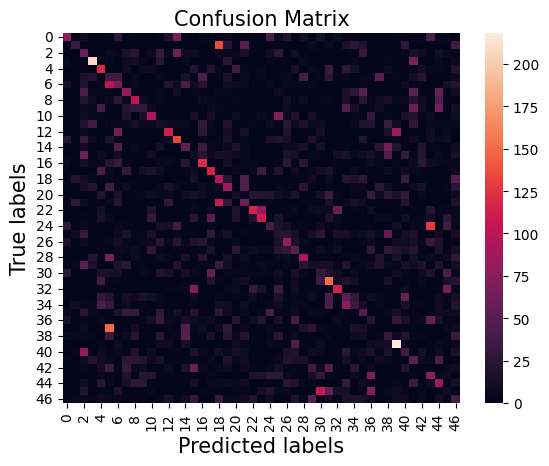

In [32]:

generate_confusion_matrix(y_test, y_pred_test)

## Part 2 - MLP

### 2.1 - Optimizing parameters

1. Find the ideal number of neurons for an ANN with one hidden layer
2. Find the ideal number of layers with the "ideal number of neurons" determined in 1

In [ ]:
# Uncomment the block below when testing number of neurons
#num_neurons = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
#num_layers = 1

# Comment the block below when testing the number of neurons
num_neurons = 900
num_layers = [1,2,3,4,5]

accuracies = []

# for num in num_neurons: # Uncomment this when testing number of neurons
for num in num_layers: # Comment this whe ntesting number of neurons
    print("Now starting: {} layers".format(num))
    # mlp = MLPClassifier(max_iter=200, hidden_layer_sizes=(num,), random_state=0) # Uncomment this when testing number of neurons
    mlp = MLPClassifier(max_iter=200, hidden_layer_sizes=([num_neurons]*num_layers), random_state=0) # Comment this when testing number of neurons
    X_train_small = X_train[:10000]
    y_train_small = y_train[:10000]
    mlp.fit(X_train_small, y_train_small)
    y_pred_tr = mlp.predict(X_train_small)
    y_pred_test = mlp.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred_test))

# Uncomment the block below when testing number of neurons
# evaluation = pd.DataFrame({
#     "num_neurons": num_neurons,
#     "accuracy": accuracies
# })
# evaluation

# Comment the block below when testing number of neurons
evaluation = pd.DataFrame({
    "num_layers": num_layers,
    "accuracy": accuracies
})
evaluation

# === RESULTS ===

# Ideal layer size analysis - Number of layers is kept constant as 1.
#       num_neurons accuracy
# 0	    100	        0.543564
# 1	    200	        0.613085
# 2	    300	        0.595851
# 3	    400	        0.600904
# 4	    500	        0.604681
# 5	    600	        0.624894
# 6	    700	        0.659894
# 7	    800	        0.646330
# 8	    900	        0.689734 <== Local maximum
# 9	    1000	    0.656011
# 10	1100	    0.672606
# 11	1200	    0.658936

# Ideal number of layers analysis - Number of neurons per layer is kept constant at 900 (as determined by the previous table)
# 	    num_layers  accuracy
# 0	    1	        0.689734
# 1	    2	        0.652181
# 2	    3	        0.700106 <== Local maximum
# 3	    4	        0.677021
# 4	    5	        0.710691 <== would take far too long to train

# Therefore, a MLP with 3 hidden layers and 900 neurons per layer is ideal.
# Of course, it's not actually ideal as varying layer sizes may lead to better results,
# however, I do not have a significant amount of computational power or time to test all possibilities.

In [ ]:
# PLEASE DO NOT OVERWRITE THE MODEL (run if you wish but I shall not do it again)
mlp_trained = MLPClassifier(random_state=0, max_iter=2, hidden_layer_sizes=(900,900,900,), verbose=True)
print("Model created")
mlp_trained.fit(X_train, y_train)
# On a Ryzen 7 5700U, it took 78 minutes to train

# Uncomment to overwrite the locally saved model
# %store mlp_trained

In [37]:
# mlp_trained is a saved variable. Layers: (900,900,900), max_iter: 100
# mlp_test is the model generated above
to_test = mlp_trained
# On training dataset
y_pred_train = to_test.predict(X_train)
y_pred_proba_train = to_test.predict_proba(X_train)
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
loss_train = metrics.log_loss(y_train, y_pred_proba_train)
print("Training Set:")
print(" - Loss: " + str(loss_train))
print(" - Accuracy: " + str(accuracy_train))
# On testing dataset
y_pred_test = to_test.predict(X_test)
y_pred_proba_test = to_test.predict_proba(X_test)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
loss_test = metrics.log_loss(y_test, y_pred_proba_test)
print("Testing Set")
print(" - Loss: " + str(loss_test))
print(" - Accuracy: " + str(accuracy_test))

# === RESULTS ===

# Training Set:
#  - Loss: 0.23752188350972647
#  - Accuracy: 0.9301152482269504
# Testing Set
#  - Loss: 1.3251768763344238
#  - Accuracy: 0.8181914893617022

/home/rv/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/rv/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Training Set:
 - Loss: 0.23752188350972647
 - Accuracy: 0.9301152482269504
Testing Set
 - Loss: 1.3251768763344238
 - Accuracy: 0.8181914893617022


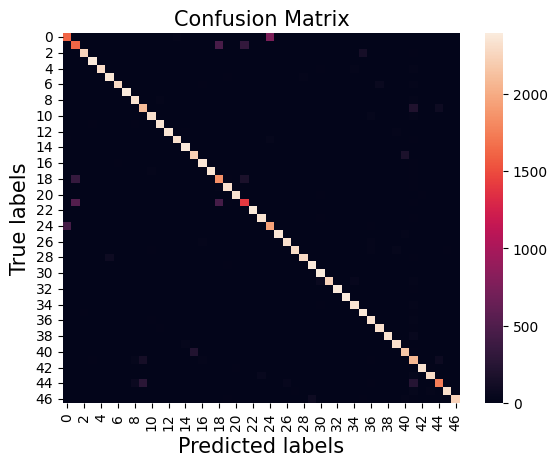

In [35]:
generate_confusion_matrix(y_train, y_pred_train)

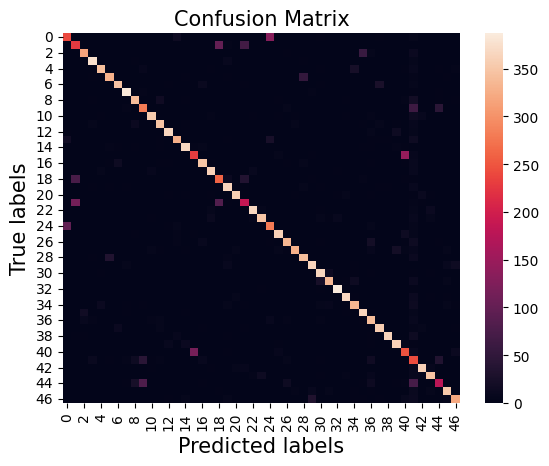

In [38]:
generate_confusion_matrix(y_test, y_pred_test)